In [2]:
import pandas as pd
import akshare as ak
from scipy.stats import norm
from scipy.optimize import minimize
import numpy as np
from math import log
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# 违约距离计算

In [108]:
import akshare as ak
def kmv_fun(model_data,year):
    list_D = []
    sharp_list = []
    record_code = []
    code = model_data["代码"].to_list()
    tot_lib = model_data["总债"].to_list()
    flow_lib = model_data["流动债"].to_list()
    nap = model_data["每股资产"].to_list()
    total_shar = model_data["总股"].to_list()
    a_shar = model_data["A股"].to_list()
    leng = len(code)
    for i in range(0,leng):
        try:    
            start_date = str(year-1)+"1231"
            end_date = str(year+1)+"0101"
            stock_zh_a_daily_qfq_df = ak.stock_zh_a_daily(symbol=code[i], start_date=start_date, end_date=end_date, adjust="qfq")
            stock_zh_a_daily_qfq_df["value"] = stock_zh_a_daily_qfq_df["outstanding_share"]*stock_zh_a_daily_qfq_df["close"]
            stock_zh_a_daily_qfq_df["next"] = stock_zh_a_daily_qfq_df["close"].shift(1)
            stock_zh_a_daily_qfq_df.dropna(inplace = True)
            n = len(stock_zh_a_daily_qfq_df["next"])
            rf = 1.5
            stock_zh_a_daily_qfq_df["change"] =(stock_zh_a_daily_qfq_df["close"]/stock_zh_a_daily_qfq_df["next"]-1)*100
            stock_zh_a_daily_qfq_df["change"] = (stock_zh_a_daily_qfq_df["change"]).apply(np.log1p) 
            std = stock_zh_a_daily_qfq_df["change"].std()
            mean = stock_zh_a_daily_qfq_df["close"].mean()
            sharp = (mean - rf)/std
            V_equity = mean*a_shar[i] + (total_shar[i]-a_shar[i]) * nap[i]
            default_point = (tot_lib[i]+flow_lib[i])/2
            rf_rate = 0.015
            sigma_equity = std 
            T = 1
            # One dimension estimation
            def equation(x):
                d1 = (np.log(x[0]/default_point) + (rf_rate+x[1]**2/2)*T)/(x[1] * np.sqrt(T))
                d2 = d1 - x[1] * np.sqrt(T)
                res1 = x[0] * norm.cdf(d1) - np.exp(-rf_rate*T) * default_point * norm.cdf(d2) - V_equity
                res2 = x[0] * norm.cdf(d1) * x[1] - V_equity * sigma_equity
                return(res1**2+res2**2)
            result = minimize(equation,[V_equity,sigma_equity])
            V_asset = list(result["x"])[0]
            sigma_asset = list(result["x"])[1]
            DD = (V_asset-default_point)/(sigma_asset*V_asset)
            list_D.append(DD)
            sharp_list.append(sharp)
            record_code.append(code[i])
        except Exception as e:
            pass
        continue
    return list_D,sharp_list,record_code

# 整理模型所需要数据

In [109]:
def process(rate_name,fin_name,share_name,year):   
    mdata = pd.read_csv(rate_name)
    share = pd.read_csv(share_name)
    fin_data = pd.read_csv(fin_name)
    #将中债隐含评级数据换为数字
    mdata.loc[(mdata["F2_0003"]== 'AAA+'),"评级"] = 10
    mdata.loc[(mdata["F2_0003"]== 'AAA')  ,"评级"] = 9
    mdata.loc[(mdata["F2_0003"]== 'AA+')|(mdata["F2_0003"]== 'AAA-')  ,"评级"] = 8
    mdata.loc[(mdata["F2_0003"]== 'AA')|(mdata["F2_0003"]== 'AA(2)'),"评级"] = 7
    mdata.loc[mdata["F2_0003"]== 'AA-',"评级"] = 6
    mdata.loc[(mdata["F2_0003"]== 'A+')  ,"评级"] = 5
    mdata.loc[(mdata["F2_0003"]== 'A'),"评级"] = 4
    mdata.loc[(mdata["F2_0003"]== 'A-'),"评级"] = 3
    mdata.loc[(mdata["F2_0003"]== 'BBB+') |( mdata["F2_0003"]== 'BBB')|( mdata["F2_0003"]== 'BBB-') ,"评级"] = 2
    mdata.loc[(mdata["F2_0003"]== 'BB') |( mdata["F2_0003"]== 'B') ,"评级"] = 1
    mdata.loc[(mdata["F2_0003"]== 'CCC') |( mdata["F2_0003"]== 'CC')|( mdata["F2_0003"]== 'C') ,"评级"] = 0
    #比较年初年末的中债数据
    first_date = min(mdata["F1_2014"])
    first = mdata.loc[mdata["F1_2014"] ==first_date ]
    final_date = max(mdata["F1_2014"])
    final = mdata.loc[mdata["F1_2014"] ==final_date ]
    #关联年末年初的数据表
    data = pd.merge(first,final,on = "OB_OBJECT_NAME_1090")
    #如果数据下降则下降等于1
    data.loc[(data['评级_x']> data['评级_y']),"下降"] = 1
    
    #和发债主体的财务数据相关联
    data = pd.merge(bond,data,left_on  ="secu_cd",right_on = "F16_1090_x")
    data = pd.merge(fin_data,data,left_on ="corp_id",right_on = "issr_id")
    data_defualt = data.loc[data["下降"]==1]
    default_company = data_defualt["issr_id"].unique()
    company = data["issr_id"].unique()


    bond_data = pd.DataFrame()
    bond_data["ID"] = company
    bond_data.loc[bond_data["ID"].isin(default_company) == 1  ,"下降"] = 1
    bond_data["下降"] =  bond_data["下降"].fillna(0)
    bond_data = pd.merge(bond_data,fin_data,left_on = "ID",right_on = "corp_id")

    bond_data = bond_data.dropna(subset=["ebitda"])
    bond_data = bond_data.fillna(0)
    bond_data.loc[(bond_data["exch_cd"]== 101),"市场"] = 'sh'
    bond_data.loc[(bond_data["exch_cd"]== 105),"市场"] = 'sz'
    bond_data = bond_data.dropna(subset=["市场"])
    bond_data['secu_cd'] = bond_data['secu_cd'].apply(lambda x : '{:0>6d}'.format(x))


    bond_data['secu_cd']= bond_data['secu_cd'].astype('str')
    bond_data['市场']= bond_data['市场'].astype('str')
    bond_data['代码'] =  bond_data['市场'] +bond_data['secu_cd']
    bond_data = pd.merge(bond_data,share)


    model_data = pd.DataFrame()
    model_data["企业"] = bond_data["ID"]
    model_data["主营业务利润率"] = bond_data["biz_prof_biz_total_ncm_rt"]
    model_data["营业成本收入比"] = bond_data["biz_cost_ncm_rt"]
    model_data["总资产报酬率"] = bond_data["total_ast_rwrd_rate_ann"]
    model_data["总资产收益率"] = bond_data["total_ast_prft_rate"]
    model_data["应收账款周转率"] = bond_data["recv_acc_tr"]
    model_data["存货周转率"] = bond_data["invt_tr"]
    model_data["流动比率"] =bond_data["flow_rt"]
    model_data["速度比率"] = bond_data["qr"]
    model_data["EBITA/带息债务"] = bond_data["ebitda"]/(bond_data["st_brow"]+bond_data["lt_brow"])
    model_data["资产负债率"] = bond_data["ast_liab_rate"]
    model_data["短期债务/总债务"] = bond_data["flow_liab_tot"]/bond_data["liab_tot"]
    model_data["货币资金/总债务"] = bond_data["crrc_fund"]/bond_data["liab_tot"]
    model_data["货币资金/短期债务"] = bond_data["crrc_fund"]/bond_data["flow_liab_tot"] 
    model_data["营业收入增长率"] = bond_data["biz_ncm_yoy_incr"]
    model_data["违约"] = bond_data["下降"]
    model_data["代码"] = bond_data["代码"]
    model_data["总债"]= bond_data["liab_tot"]
    model_data["流动债"]= bond_data["flow_liab_tot"]
    model_data["每股资产"]= bond_data["naps"]
    model_data["总股"]= bond_data["total_shar"]
    model_data["A股"]= bond_data["a_shr"]

    list_D,sharp_list,record_code = kmv_fun(model_data,year)
    kmv = pd.DataFrame()
    kmv["代码"] = record_code
    kmv["sharp"] = sharp_list
    kmv["违约距离"] =list_D
    kmv = kmv.dropna()
    model_data = pd.merge(kmv,model_data)
    model_data = model_data.drop(columns=["代码","流动债", "每股资产", "总股", "A股","总债"])
    model_data
    model_data =model_data.replace([np.inf, -np.inf], np.nan) 
    model_data = model_data.dropna()
    return model_data

In [112]:
bond = pd.read_csv("new bond.csv")
data_2018 = process("2018 中债.csv","2018  data.csv","2018 share data.csv",2018)
data_2019 = process("2019 中债.csv","2019  data.csv","2019 share data.csv",2019)
data_2020 = process("2020 中债.csv","2020  data.csv","2020 share data.csv",2018)



NameError: name 'data_2015' is not defined

In [113]:
model_data = pd.concat([ data_2018,data_2019,data_2020])
model_data

,sharp,违约距离,企业,主营业务利润率,营业成本收入比,总资产报酬率,总资产收益率,应收账款周转率,存货周转率,流动比率,速度比率,EBITA/带息债务,资产负债率,短期债务/总债务,货币资金/总债务,货币资金/短期债务,营业收入增长率,违约,总债
0,4.565464,0.808592,f158d755c434323d5212ea2d976cc650,-31.6248,133.4583,-5.8620,-8.4665,1.3224,2.1950,0.8970,0.7422,-0.142033,72.7562,0.774268,0.135687,0.175246,-13.3615,0.0,9.759788e+09
1,2.916379,0.899219,69c102d24aa5434dd08ff48ebf25eab3,11.0070,87.4976,3.0409,0.9621,329.0293,0.1707,2.4928,0.4452,0.394086,46.0663,0.729240,0.292811,0.401528,24.0297,0.0,4.457512e+09
2,6.103240,0.834711,1e6a20aaf0d282b2bca0b11e6ac41d03,6.9669,94.4574,7.0798,4.9132,2.6953,4.2784,1.9589,1.3932,0.447760,32.9870,0.988037,0.196694,0.199075,27.1263,0.0,1.543439e+09
3,3.405076,1.141728,65a3f71b995f65ccf5900b3ce41bc9ab,-23.7977,125.4409,17.3928,13.1278,27.9557,7.2261,2.5257,1.9592,26.285066,20.8335,0.789756,1.100705,1.393728,9.7500,1.0,5.713657e+08
4,1.572960,0.561652,97fbc2feb2560285b796de83253d1ea9,-30.2099,130.2196,-10.1132,-10.4972,24.8359,8.6278,0.3220,0.2602,-0.389769,89.3720,0.775434,0.123651,0.159460,1.9842,1.0,2.046993e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,12.124535,0.996097,43c45628876583a487da5b38bd9d5da6,-79.5811,185.6009,-12.3347,-13.9376,1.2601,0.8318,0.9544,0.7842,-0.350508,58.2644,0.468324,0.192813,0.411708,17.5079,0.0,2.342420e+09
223,5.336738,0.809694,69b2d203dc2a5b2d0f25bcf231f3f1f3,26.5773,78.3613,5.7279,3.0340,114.4625,0.1884,1.6177,0.5294,0.217944,75.8260,0.664743,0.174742,0.262872,36.3899,0.0,3.462127e+11
224,8.500039,0.946870,1d33c89b4c3a789c4ef8973af0ee94eb,5.1779,95.3787,7.1478,4.3068,17.5362,12.3742,1.1948,1.0239,0.202478,63.7047,0.727038,0.427637,0.588192,-37.0356,0.0,1.791623e+10
225,10.255216,1.001807,b29cdb4ddf975881440891efbe09b90b,-13.8685,115.1112,-5.6768,-6.7305,2.4469,1.3309,2.0223,1.5077,-0.528560,46.7898,0.785340,0.407733,0.519180,-26.6793,0.0,6.380930e+09


# 使用Linear Reg 进行预测

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
y = model_data["违约"]
X = model_data.drop(columns=['企业', '违约'])



X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7, test_size=0.3, random_state=188)
clf = LogisticRegression( max_iter=3000)

# 使用训练数据来学习（拟合），不需要返回值，训练的结果都在对象内部变量中
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
lr_train = clf.score(X_train,y_train)
lr_train_pre = precision_score(y_train, y_pred)
lr_train_recall= recall_score(y_train, y_pred)

y_pred = clf.predict(X_test)
lr_test = clf.score(X_test,y_test)
lr_test_pre = precision_score(y_test, y_pred)
lr_test_recall= recall_score(y_test, y_pred)

# 使用XG boost 进行预测，绘制重要性表

In [132]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

other_params = {'scale_pos_weight': 7,'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 20,'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.001, 'subsample': 0.6}
xgboost_model = xgb.XGBClassifier(**other_params)

param_grid = {'gamma': [0.1, 0.2, 0.3,0.01,0.05],'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [ 0.8, 0.9,1],'learning_rate': [1e-5,1e-4,1e-3,1e-2,1e-1,1]}


kflod = StratifiedKFold(n_splits=10, shuffle = True,random_state=7)#将训练/测试数据集划分10个互斥子集，
 
grid_search = GridSearchCV(xgboost_model,param_grid,n_jobs = -1,cv = 3,scoring = "f1")
grid_result = grid_search.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))


0.319504  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 1e-05, 'subsample': 0.6}
0.275045  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 1e-05, 'subsample': 0.7}
0.256778  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 1e-05, 'subsample': 0.8}
0.263434  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 1e-05, 'subsample': 0.9}
0.318147  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.0001, 'subsample': 0.6}
0.277953  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.0001, 'subsample': 0.7}
0.257898  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.0001, 'subsample': 0.8}
0.262495  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.0001, 'subsample': 0.9}
0.318147  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.001, 'subsample': 0.6}
0.279128  with:   {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.001, 'subsample': 0

In [133]:

print('最优参数组合:', grid_result.best_params_, '最好得分:', grid_result.best_score_)


最优参数组合: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.001, 'subsample': 0.6} 最好得分: 0.3274035296699163


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

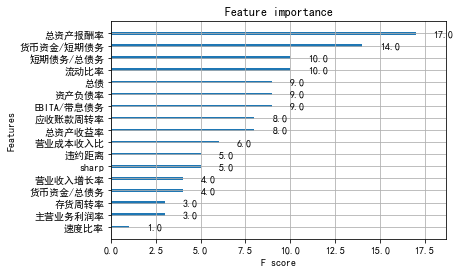

In [134]:
other_params = {'scale_pos_weight': 7,'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 20,'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.001, 'subsample': 0.6}
xgboost_model = xgb.XGBClassifier(**other_params).fit(X_train,y_train)





#plot_importance(xgboost_model)
pred = xgboost_model.predict(X_train)
xgb_train = xgboost_model.score(X_train,y_train)
xgb_train_pre = precision_score(y_train, pred)
xgb_train_recall = recall_score(y_train, pred)

pred = xgboost_model.predict(X_test)
xgb_test = xgboost_model.score(X_test,y_test)
xgb_test_pre = precision_score(y_test, pred)
xgb_test_recall =  recall_score(y_test, pred)
plot_importance(xgboost_model)

In [135]:
xgb_test_recall

0.46153846153846156